## Семинар 2: Динамическое программирование
### Майнор ВШЭ, 24.01.2019

Рассмотрим алгоритм итерации по оценкам состояниям $V$ (Value Iteration):

---

`1.` Initialize $V^{(0)}(s)=0$, for all $s$

`2.` For $i=0, 1, 2, \dots$
 
`3.` $ \quad V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$, for all $s$

---

На основе оценки $V_i$ можно посчитать функцию оценки $Q_i$ действия $a$ в состоянии $s$:

$$Q_i(s, a) = \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$$

$$V_{(i+1)}(s) = \max_a Q_i(s,a)$$

Зададим напрямую модель MDP с картинки:

<img src="mdp.png" style="width: 400px;"/>

In [28]:
transition_probs = {
  's0':{
    'a0': {'s0': 0.5, 's2': 0.5},
    'a1': {'s2': 1}
  },
  's1':{
    'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
    'a1': {'s1': 0.95, 's2': 0.05}
  },
  's2':{
    'a0': {'s0': 0.4, 's1': 0.6},
    'a1': {'s0': 0.3, 's1': 0.3, 's2':0.4}
  }
}
rewards = {
  's1': {'a0': {'s0': +5}},
  's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

In [29]:
print("mdp.get_all_states =", mdp.get_all_states())
print("mdp.get_possible_actions('s1') = ", mdp.get_possible_actions('s1'))
print("mdp.get_next_states('s1', 'a0') = ", mdp.get_next_states('s1', 'a0'))
print("mdp.get_reward('s1', 'a0', 's0') = ", mdp.get_reward('s1', 'a0', 's0'))
print("mdp.get_transition_prob('s1', 'a0', 's0') = ", mdp.get_transition_prob('s1', 'a0', 's0'))

mdp.get_all_states = ('s0', 's1', 's2')
mdp.get_possible_actions('s1') =  ('a0', 'a1')
mdp.get_next_states('s1', 'a0') =  {'s0': 0.7, 's1': 0.1, 's2': 0.2}
mdp.get_reward('s1', 'a0', 's0') =  5
mdp.get_transition_prob('s1', 'a0', 's0') =  0.7


### Задание 1

Реализуем итерационное вычисление функций $V$ и $Q$ и применим их для заданого вручную MDP.

Вначале вычисляем оценку состояния-действия:

$$Q_i(s, a) = \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$$

In [30]:
def get_action_value(mdp, state_values, state, action, gamma):
    """ Computes Q(s,a) as in formula above """
    
    
    Q = sum([(prob * (mdp.get_reward(state, action, s) + gamma * state_values[s])) 
             for s, prob in mdp.get_next_states(state, action).items()])
    
    return Q

In [31]:
test_Vs = {s : i for i, s in enumerate(sorted(mdp.get_all_states()))}
assert np.allclose(get_action_value(mdp, test_Vs, 's2', 'a1', 0.9), 0.69)

Теперь оцениваем полезность самого состоия:

$$V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = \max_a Q_i(s,a)$$

In [32]:
def get_new_state_value(mdp, state_values, state, gamma):
    """ Computes next V(s) as in formula above. Please do not change state_values in process. """
    if mdp.is_terminal(state): return 0
    
    V = max([sum([prob*(mdp.get_reward(state, action, s) + gamma * state_values[s]) 
                  for s, prob in mdp.get_next_states(state, action).items()])
             for action in mdp.get_possible_actions(state)])
    return V

In [33]:
test_Vs_copy = dict(test_Vs)
assert np.allclose(get_new_state_value(mdp, test_Vs, 's0', 0.9), 1.8)

Теперь создаем основной цикл итерационного оценки полезности состояний с критерием остановки, который проверяет насколько изменились оценки.

In [34]:
def value_iteration(mdp, state_values=None, gamma = 0.9, num_iter = 1000, min_difference = 1e-5):
    """ performs num_iter value iteration steps starting from state_values"""
    # initialize V(s)
    state_values = state_values or {s : 0 for s in mdp.get_all_states()}
    for i in range(num_iter):

        # Compute new state values using the functions you defined above. It must be a dict {state : new_V(state)}
        new_state_values = {s : get_new_state_value(mdp, state_values, s, gamma) for s in mdp.get_all_states()}
        
        assert isinstance(new_state_values, dict)

        # Compute difference
        diff =  max(abs(new_state_values[s] - state_values[s]) for s in mdp.get_all_states())
        
        print("iter %4i   |   diff: %6.5f   |   V(start): %.3f "%(i, diff, new_state_values[mdp._initial_state]))
        
        state_values = new_state_values
        if diff < min_difference:
            print("Converged")
            break
            
    return state_values

value_iteration(mdp, num_iter = 100, min_difference = 0.001)

iter    0   |   diff: 3.50000   |   V(start): 0.000 
iter    1   |   diff: 1.89000   |   V(start): 0.000 
iter    2   |   diff: 1.70100   |   V(start): 1.701 
iter    3   |   diff: 1.13542   |   V(start): 1.854 
iter    4   |   diff: 0.73024   |   V(start): 2.584 
iter    5   |   diff: 0.61135   |   V(start): 3.186 
iter    6   |   diff: 0.54664   |   V(start): 3.590 
iter    7   |   diff: 0.49198   |   V(start): 4.082 
iter    8   |   diff: 0.42210   |   V(start): 4.463 
iter    9   |   diff: 0.36513   |   V(start): 4.816 
iter   10   |   diff: 0.32862   |   V(start): 5.145 
iter   11   |   diff: 0.29262   |   V(start): 5.429 
iter   12   |   diff: 0.26189   |   V(start): 5.691 
iter   13   |   diff: 0.23503   |   V(start): 5.925 
iter   14   |   diff: 0.21124   |   V(start): 6.135 
iter   15   |   diff: 0.19012   |   V(start): 6.325 
iter   16   |   diff: 0.17091   |   V(start): 6.496 
iter   17   |   diff: 0.15366   |   V(start): 6.649 
iter   18   |   diff: 0.13830   |   V(start): 

{'s0': 8.023123818663871, 's1': 11.163174814980803, 's2': 8.915559364985523}

In [35]:
print("Final state values:", state_values)

assert abs(state_values['s0'] - 8.032)  < 0.01

Final state values: {'s0': 8.023123818663871, 's1': 11.163174814980803, 's2': 8.915559364985523}


По найденным полезностям и зная модель переходов легко найти опитмальную стратегию:

$$\pi^*(s) = argmax_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = argmax_a Q_i(s,a)$$

In [36]:
def get_optimal_action(mdp, state_values, state, gamma=0.9):
    """ Finds optimal action using formula above. """
    if mdp.is_terminal(state): return None
    
    actions = mdp.get_possible_actions(state)
    i = np.argmax([get_action_value(mdp, state_values, state, action, gamma) for action in actions])
    
    
    return actions[i]

In [37]:
assert get_optimal_action(mdp, state_values, 's0', gamma) == 'a1'

### Задание 2

Теперь проверим работу итерации по ценностям на классической задаче FrozenLake.

In [38]:
from mdp import FrozenLakeEnv
mdp = FrozenLakeEnv(slip_chance=0)

mdp.render()

*FFF
FHFH
FFFH
HFFG



In [39]:
state_values = value_iteration(mdp)

iter    0   |   diff: 1.00000   |   V(start): 0.000 
iter    1   |   diff: 0.90000   |   V(start): 0.000 
iter    2   |   diff: 0.81000   |   V(start): 0.000 
iter    3   |   diff: 0.72900   |   V(start): 0.000 
iter    4   |   diff: 0.65610   |   V(start): 0.000 
iter    5   |   diff: 0.59049   |   V(start): 0.590 
iter    6   |   diff: 0.00000   |   V(start): 0.590 
Converged


Визуализируем нашу стратегию.

In [40]:
def draw_policy(mdp, state_values):
    plt.figure(figsize=(3,3))
    h,w = mdp.desc.shape
    states = sorted(mdp.get_all_states())
    V = np.array([state_values[s] for s in states])
    Pi = {s: get_optimal_action(mdp, state_values, s, gamma) for s in states}
    plt.imshow(V.reshape(w,h), cmap='gray', interpolation='none', clim=(0,1))
    ax = plt.gca()
    ax.set_xticks(np.arange(h)-.5)
    ax.set_yticks(np.arange(w)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {'left': (-1, 0), 'down':(0, -1), 'right':(1,0), 'up':(-1, 0)}
    for y in range(h):
        for x in range(w):
            plt.text(x, y, str(mdp.desc[y,x].item()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
            a = Pi[y, x]
            if a is None: continue
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.1, head_length=0.1) 
    plt.grid(color='b', lw=2, ls='-')
    plt.show()

after iteration 29
iter    0   |   diff: 0.00000   |   V(start): 0.198 
Converged


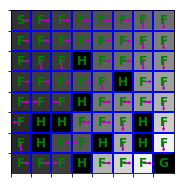

In [42]:
from IPython.display import clear_output
from time import sleep

mdp = FrozenLakeEnv(map_name='8x8',slip_chance=0.1)
state_values = {s : 0 for s in mdp.get_all_states()}

for i in range(30):
    clear_output(True)
    print("after iteration %i"%i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
    sleep(0.5)
# please ignore iter 0 at each step

Тестируем на различных вариантах окружения.

In [43]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.2, map_name='8x8')
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done: break
    total_rewards.append(np.sum(rewards))
    
print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.8)
print("Well done!")

iter    0   |   diff: 0.80000   |   V(start): 0.000 
iter    1   |   diff: 0.57600   |   V(start): 0.000 
iter    2   |   diff: 0.41472   |   V(start): 0.000 
iter    3   |   diff: 0.29860   |   V(start): 0.000 
iter    4   |   diff: 0.24186   |   V(start): 0.000 
iter    5   |   diff: 0.19349   |   V(start): 0.000 
iter    6   |   diff: 0.15325   |   V(start): 0.000 
iter    7   |   diff: 0.12288   |   V(start): 0.000 
iter    8   |   diff: 0.09930   |   V(start): 0.000 
iter    9   |   diff: 0.08037   |   V(start): 0.000 
iter   10   |   diff: 0.06426   |   V(start): 0.000 
iter   11   |   diff: 0.05129   |   V(start): 0.000 
iter   12   |   diff: 0.04330   |   V(start): 0.000 
iter   13   |   diff: 0.03802   |   V(start): 0.033 
iter   14   |   diff: 0.03332   |   V(start): 0.058 
iter   15   |   diff: 0.02910   |   V(start): 0.087 
iter   16   |   diff: 0.01855   |   V(start): 0.106 
iter   17   |   diff: 0.01403   |   V(start): 0.120 
iter   18   |   diff: 0.00810   |   V(start): 

### Задание 3

Теперь рассмотрим следующий алгоритм - итерации по стратегиям (PI):

---
Initialize $\pi_0$   `// random or fixed action`

For $n=0, 1, 2, \dots$
- Compute the state-value function $V^{\pi_{n}}$
- Using $V^{\pi_{n}}$, compute the state-action-value function $Q^{\pi_{n}}$
- Compute new policy $\pi_{n+1}(s) = \operatorname*{argmax}_a Q^{\pi_{n}}(s,a)$
---

PI включает в себя оценку полезности состояния как внутренний шаг.

Вначале оценим полезности, используя текущую стартегию:

$$V^{\pi}(s) = \sum_{s'} P(s,\pi(s),s')[ R(s,\pi(s),s') + \gamma V^{\pi}(s')]$$

Мы будем пытаться найти точное решение, хотя могли использовать и предыдущий итерационный подход. Для этого будем решать систему линейных уравнений с помощью `np.linalg.solve`.

In [52]:
from numpy.linalg import solve

def compute_vpi(mdp, policy, gamma):
    """
    Computes V^pi(s) FOR ALL STATES under given policy.
    :param policy: a dict of currently chosen actions {s : a}
    :returns: a dict {state : V^pi(state) for all states}
    """
    states = mdp.get_all_states()
    A, b = [], []
    for i, state in enumerate(states):
        if state in policy:
            a = policy[state]
            A.append([(1-gamma * mdp.get_transition_prob(state, a, s) if i == j else -gamma * mdp.get_transition_prob(state, a, s)) 
                  for j, s in enumerate(states)])
            b.append(sum([prob * mdp.get_reward(state, a, next_state) 
                      for next_state, prob in mdp.get_next_states(state, a).items()]))
        else:
            A.append([(1 if i == j else 0) for j, s in enumerate(states)])
            b.append(0)
    A = np.array(A)
    b = np.array(b)
    
    values = solve(A, b)
    
    state_values = {states[i] : values[i] for i in range(len(states))}
    return state_values

In [53]:
transition_probs = {
  's0':{
    'a0': {'s0': 0.5, 's2': 0.5},
    'a1': {'s2': 1}
  },
  's1':{
    'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
    'a1': {'s1': 0.95, 's2': 0.05}
  },
  's2':{
    'a0': {'s0': 0.4, 's1': 0.6},
    'a1': {'s0': 0.3, 's1': 0.3, 's2':0.4}
  }
}
rewards = {
  's1': {'a0': {'s0': +5}},
  's2': {'a1': {'s0': -1}}
}
mdp = MDP(transition_probs, rewards, initial_state='s0')

gamma = 0.9            # discount for MDP

test_policy = {s: np.random.choice(mdp.get_possible_actions(s)) for s in mdp.get_all_states()}
new_vpi = compute_vpi(mdp, test_policy, gamma)

print(new_vpi)

assert type(new_vpi) is dict, "compute_vpi must return a dict {state : V^pi(state) for all states}"

{'s0': 2.8399699474079663, 's1': 6.498873027798649, 's2': 3.4710743801652932}


Теперь обновляем стратегию на основе новых значений полезностей.

In [54]:
def compute_new_policy(mdp, vpi, gamma):
    """
    Computes new policy as argmax of state values
    :param vpi: a dict {state : V^pi(state) for all states}
    :returns: a dict {state : optimal action for all states}
    """
    Q = {}
    for state in mdp.get_all_states():
        Q[state] = {}
        for a in mdp.get_possible_actions(state):
            values = [] 
            for next_state in mdp.get_next_states(state, a):
                r = mdp.get_reward(state, a, next_state)
                p = mdp.get_transition_prob(state, a, next_state)
                values.append(p * (r + gamma * vpi[state]))
            Q[state][a] = sum(values)
    
    policy ={}
    for state in mdp.get_all_states():
        actions = mdp.get_possible_actions(state)
        if actions:
            i = np.argmax(Q[state][a] for a in actions)
            policy[state] = mdp.get_possible_actions(state)[i]
            
    return policy

In [55]:
new_policy = compute_new_policy(mdp, new_vpi, gamma)

print(new_policy)

assert type(new_policy) is dict, "compute_new_policy must return a dict {state : optimal action for all states}"

{'s0': 'a0', 's1': 'a0', 's2': 'a0'}


Собираем все в единый цикл.

In [56]:
def policy_iteration(mdp, policy=None, gamma = 0.9, num_iter = 1000, min_difference = 1e-5):
    """ 
    Run the policy iteration loop for num_iter iterations or till difference between V(s) is below min_difference.
    If policy is not given, initialize it at random.
    """
    for i in range(num_iter):
        if not policy:
            policy = {}
            for s in mdp.get_all_states():
                if mdp.get_possible_actions(s):
                    np.random.choice(mdp.get_possible_actions(s))
            
        state_values = compute_vpi(mdp, policy, gamma)
        
        policy = compute_new_policy(mdp, state_values, gamma)    
        
    
    return state_values, policy

Тестируем на FrozenLake.

In [58]:
mdp = FrozenLakeEnv(slip_chance=0.1)
state_values, policy = policy_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(policy[s])
        rewards.append(r)
        if done: break
    total_rewards.append(np.sum(rewards))
    
print("average reward: ", np.mean(total_rewards))
#assert(0.8 <= np.mean(total_rewards) <= 0.95)
print("Well done!")

average reward:  0.0
Well done!
